In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf

from utils import *

Setting up the devices for torch.

In [13]:
try:
  import torch_xla
  import torch_xla.core.xla_model as xm
  device = xm.xla_device()
  print("TPU is available. Using TPU")
except:
  if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
  else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


In [14]:
torch.manual_seed(42)
np.random.seed(42)

In [15]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

**Loading the test and training data along with the labels**

In [16]:
train_data.shape
train_data = train_data.reshape(60000, -1).astype(np.float32) / 255.0
train_labels = train_labels.reshape(60000, -1).astype(np.float32).flatten()

train_data = torch.tensor(train_data)
train_labels = torch.tensor(train_labels).long()

test_data = test_data.reshape(10000, -1).astype(np.float32) / 255.0
test_labels = test_labels.reshape(10000, -1).astype(np.float32).flatten()

test_data = torch.tensor(test_data)
test_labels = torch.tensor(test_labels)

In [17]:
(f_train_data, f_train_labels) , (f_test_data, f_test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [18]:
f_train_data.shape
f_train_data = f_train_data.reshape(60000, -1).astype(np.float32) / 255.0
f_train_labels = f_train_labels.reshape(60000, -1).flatten()

f_train_data = torch.tensor(f_train_data)   
f_train_labels = torch.tensor(f_train_labels).long()

f_test_data = f_test_data.reshape(10000, -1).astype(np.float32) / 255.0
f_test_labels = f_test_labels.reshape(10000, -1).flatten()

f_test_data = torch.tensor(f_test_data)
f_test_labels = torch.tensor(f_test_labels)

In [19]:
#Passing one hot encoded labels to the model. NOT requiered since pytorch Crossentropy loss can directly take the labels as integers. Nonetheless, I have kept the code for reference.

# one_hot_train_labels = [[0 for i in range(10)] for j in range(60000)]
# for i in range(60000):
#     one_hot_train_labels[i][int(train_labels[i].item())] = 1

# one_hot_train_labels = torch.tensor(one_hot_train_labels)

# one_hot_test_labels = [[0 for i in range(10)] for j in range(10000)]
# for i in range(10000):
#     one_hot_test_labels[i][int(test_labels[i].item())] = 1

# one_hot_test_labels = torch.tensor(one_hot_test_labels)

In [20]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer_1 = nn.Linear(784,128)
        self.layer_2 = nn.Linear(128,32)
        self.layer_3 = nn.Linear(32,20)
        self.layer_4 = nn.Linear(20,10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_4(x)
        return x

In [21]:
def train(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [22]:
net = Model().to(device)
train(net, 0.001, train_data.to(device), train_labels.to(device), 2000)

Epoch 0 loss: 2.310733
Epoch 100 loss: 0.299586
Epoch 200 loss: 0.162643
Epoch 300 loss: 0.102998
Epoch 400 loss: 0.065088
Epoch 500 loss: 0.039989
Epoch 600 loss: 0.023508
Epoch 700 loss: 0.013423
Epoch 800 loss: 0.007667
Epoch 900 loss: 0.004518
Epoch 1000 loss: 0.002726
Epoch 1100 loss: 0.001787
Epoch 1200 loss: 0.001252
Epoch 1300 loss: 0.000922
Epoch 1400 loss: 0.000704
Epoch 1500 loss: 0.000554
Epoch 1600 loss: 0.000446
Epoch 1700 loss: 0.000365
Epoch 1800 loss: 0.000304
Epoch 1900 loss: 0.000256


0.00021891634969506413

In [23]:
def predict(net, X):
    net.eval()
    with torch.no_grad():
        return net(X)

In [24]:
ans = predict(net, test_data.to(device))

finans = torch.argmax(ans, dim = 1).cpu().numpy()

print("The accuracy using the MLP is:", calculate_accuracy(finans, test_labels.numpy()))
print("\nThe per class precision and recall using the MLP is : \n")
MLP_metrics = calculate_metrics(finans, test_labels.numpy())
display(MLP_metrics)

The accuracy using the MLP is: 0.9701

The per class precision and recall using the MLP is : 



,class,precision,recall,f1 score
1,0,0.987755,0.974824,0.981247
2,1,0.988546,0.983348,0.98594
3,2,0.959302,0.973451,0.966325
4,3,0.972277,0.954325,0.963217
5,4,0.974542,0.97355,0.974046
6,5,0.960762,0.976082,0.968362
7,6,0.974948,0.97801,0.976477
8,7,0.969844,0.961427,0.965617
9,8,0.947639,0.958463,0.95302
10,9,0.962339,0.967131,0.964729



The confusion matrix using the MLP is : 



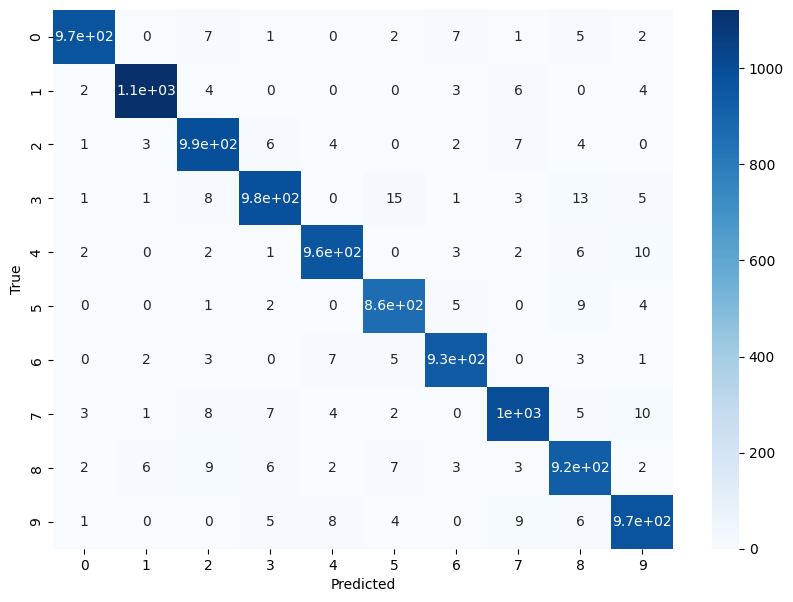

The top commonly confused classes are:
3  is interpreted to be  5
3  is interpreted to be  8
4  is interpreted to be  9
7  is interpreted to be  9
5  is interpreted to be  8
8  is interpreted to be  2
9  is interpreted to be  7
3  is interpreted to be  2
7  is interpreted to be  2
9  is interpreted to be  4


In [25]:
print("\nThe confusion matrix using the MLP is : \n")
CM_MLP = calculate_and_plot_confusion_matrix(finans, test_labels.numpy())
pick_outliers(CM_MLP)

In [26]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=64, min_samples_split=2, random_state=42)

random_forest.fit(train_data.cpu(), train_labels.cpu())
random_forest_pred = random_forest.predict(test_data)

In [27]:
print("The accuracy using the random forest is:", calculate_accuracy(random_forest_pred, test_labels.numpy()))
print("\nThe per class precision and recall using the Random Forest is : \n")
RF_metrics = calculate_metrics(random_forest_pred, test_labels.numpy())
display(RF_metrics)

The accuracy using the random forest is: 0.9704

The per class precision and recall using the Random Forest is : 



,class,precision,recall,f1 score
1,0,0.990816,0.968096,0.979324
2,1,0.992952,0.98773,0.990334
3,2,0.97093,0.961612,0.966249
4,3,0.962376,0.96333,0.962853
5,4,0.972505,0.97449,0.973496
6,5,0.964126,0.976163,0.970107
7,6,0.978079,0.976042,0.977059
8,7,0.962062,0.971513,0.966764
9,8,0.954825,0.961737,0.958269
10,9,0.952428,0.961962,0.957171



The confusion matrix using the Random Forest is : 



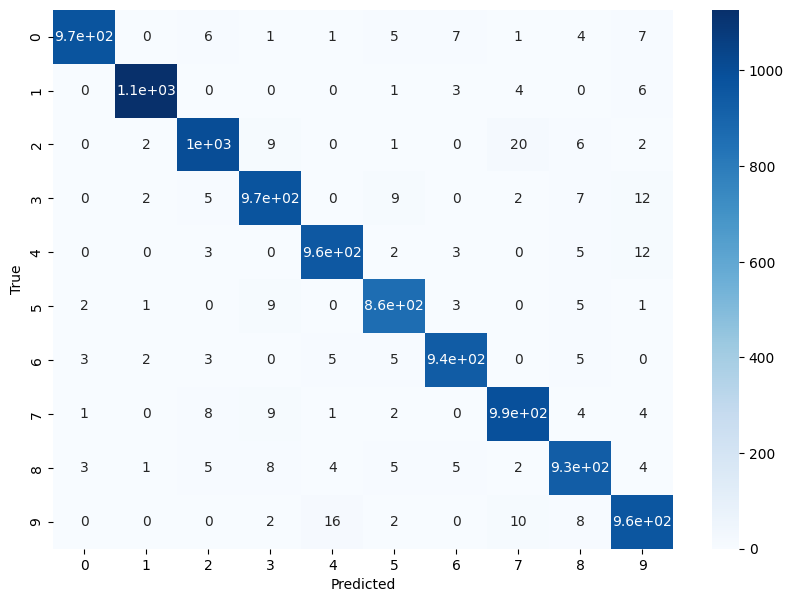

The top commonly confused classes are:
2  is interpreted to be  7
9  is interpreted to be  4
3  is interpreted to be  9
4  is interpreted to be  9
9  is interpreted to be  7
2  is interpreted to be  3
3  is interpreted to be  5
5  is interpreted to be  3
7  is interpreted to be  3
7  is interpreted to be  2


In [28]:
print("\nThe confusion matrix using the Random Forest is : \n")
CM_RF = calculate_and_plot_confusion_matrix(random_forest_pred, test_labels.numpy())
pick_outliers(CM_RF)

In [29]:
class LogisticModel(nn.Module):
    def __init__(self):
        super(LogisticModel, self).__init__()
        self.layer_1 = nn.Linear(784,10)

    def forward(self, x):
        x = self.layer_1(x)
        return x
    
def train_logistic(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [30]:
logistic_model = LogisticModel().to(device)
train_logistic(logistic_model, 0.0006, train_data.to(device), train_labels.to(device), 2000)

Epoch 0 loss: 2.278277
Epoch 100 loss: 0.852207
Epoch 200 loss: 0.587946
Epoch 300 loss: 0.484671
Epoch 400 loss: 0.428873
Epoch 500 loss: 0.393538
Epoch 600 loss: 0.368931
Epoch 700 loss: 0.350671
Epoch 800 loss: 0.336490
Epoch 900 loss: 0.325093
Epoch 1000 loss: 0.315687
Epoch 1100 loss: 0.307757
Epoch 1200 loss: 0.300956
Epoch 1300 loss: 0.295040
Epoch 1400 loss: 0.289832
Epoch 1500 loss: 0.285200
Epoch 1600 loss: 0.281047
Epoch 1700 loss: 0.277294
Epoch 1800 loss: 0.273880
Epoch 1900 loss: 0.270757


0.2679133713245392

In [31]:
logistic_pred = predict(logistic_model, test_data.to(device))

finans_logistic = torch.argmax(logistic_pred, dim = 1).cpu().numpy()

In [32]:
print("The accuracy using the logistic regression is:", calculate_accuracy(finans_logistic, test_labels.numpy()))
print("\nThe per class precision and recall using the logistic regression is : \n")
LR_metrics = calculate_metrics(finans_logistic, test_labels.numpy())
display(LR_metrics)

The accuracy using the logistic regression is: 0.9247

The per class precision and recall using the logistic regression is : 



,class,precision,recall,f1 score
1,0,0.976531,0.954138,0.965204
2,1,0.977093,0.96687,0.971954
3,2,0.886628,0.933673,0.909543
4,3,0.913861,0.90668,0.910256
5,4,0.936864,0.926485,0.931646
6,5,0.871076,0.909836,0.890034
7,6,0.955115,0.932722,0.943785
8,7,0.921206,0.929342,0.925256
9,8,0.894251,0.868395,0.881133
10,9,0.904856,0.911178,0.908006



The confusion matrix using the Logistic Regresssion is : 



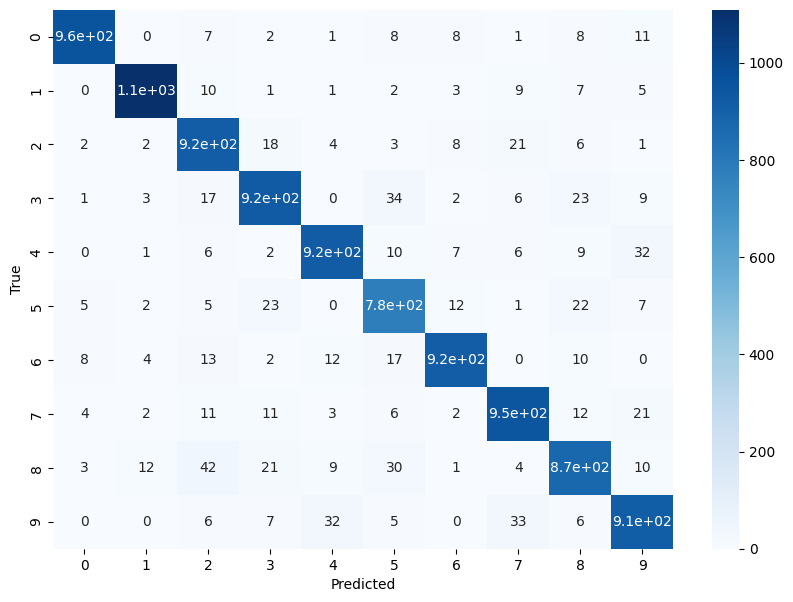

The top commonly confused classes are:
8  is interpreted to be  2
3  is interpreted to be  5
9  is interpreted to be  7
4  is interpreted to be  9
9  is interpreted to be  4
8  is interpreted to be  5
3  is interpreted to be  8
5  is interpreted to be  3
5  is interpreted to be  8
2  is interpreted to be  7


In [33]:
print("\nThe confusion matrix using the Logistic Regresssion is : \n")
CM_RF = calculate_and_plot_confusion_matrix(finans_logistic, test_labels.numpy())
pick_outliers(CM_RF)

|Model |Accuracy|
|-------|-------|
|MLP     |  97.01 %      |
|RF      |  97.04 %      |
|LR      |  92.47%       |

We observe that the accuracy for MLP and Random Forest models are comparable followed by the Vanilla Logistic Regression Model. By increasing the number of hidden layers in the MLP we can also get a bit higher accuracy to the Random Forest model. But to get a higher accuracy excedding 97 percent, it is better suited to use Convolutional Neural Networks or RNNs.

In [34]:
def get_outputs(model, data, layer):
    outputs = None
    def hook(module, input, output):
        nonlocal outputs
        outputs = (output.detach().cpu().numpy())
    
    handle = layer.register_forward_hook(hook)
    model.eval()
    with torch.no_grad():
        model(data.to(device))
        
    handle.remove()

    return outputs

trained_outputs = get_outputs(net, test_data, net.layer_2)

untrained_net = Model().to(device)

untrained_outputs = get_outputs(untrained_net, test_data, untrained_net.layer_2)

tsne = TSNE(n_components=2, random_state=42)
trained_tsne_results = tsne.fit_transform(trained_outputs)
untrained_tsne_results = tsne.fit_transform(untrained_outputs)


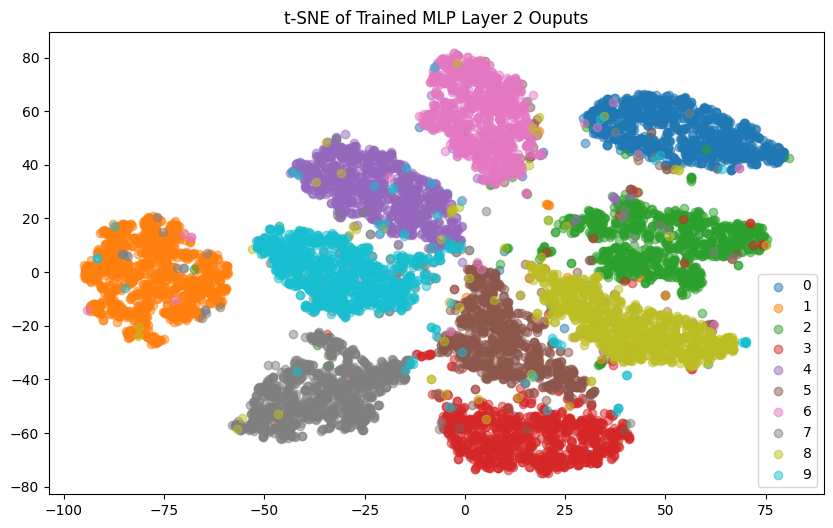

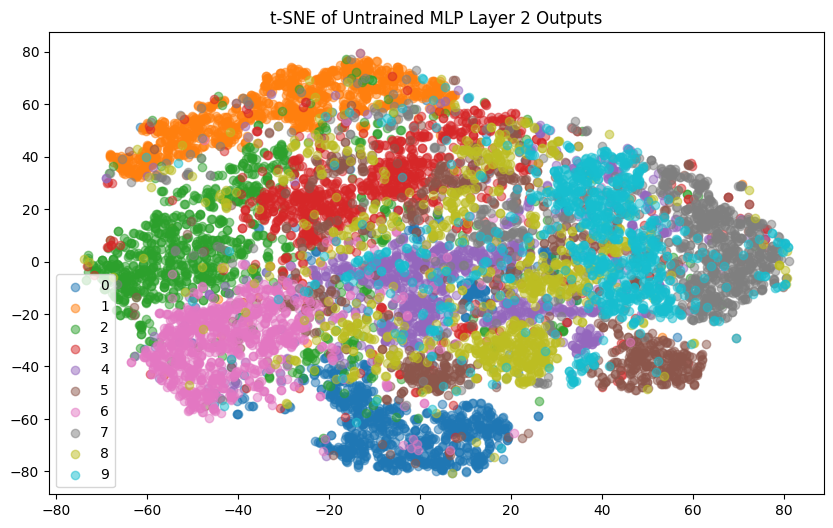

In [35]:
def plot_tsne(tsne_results, labels, title):
    plt.figure(figsize=(10, 6))
    for i in range(10):
        indices = (labels == i)
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label= i , alpha=0.5)
    plt.legend()
    plt.title(title)
    plt.show()

plot_tsne(trained_tsne_results, test_labels.numpy(), "t-SNE of Trained MLP Layer 2 Ouputs")

plot_tsne(untrained_tsne_results, test_labels.numpy(), "t-SNE of Untrained MLP Layer 2 Outputs")

From the plots of the outputs from the second layer for both the trained and untrained model, we can see that the MLP has learnt features in a manner that allows it seperate the 10 different classes of the dataset. In the untrained model's t-SNE plot, there no clear seperation between the different classes, whereas in the trained model, this seperation is very apparent with only a few outliers in the seperated regions.

An additional thing to notice is that, the t-SNE plot allows us to visualise the commonly confused classes as their regions are closer by, allowing for overlap.

Accuracy is :  0.1009


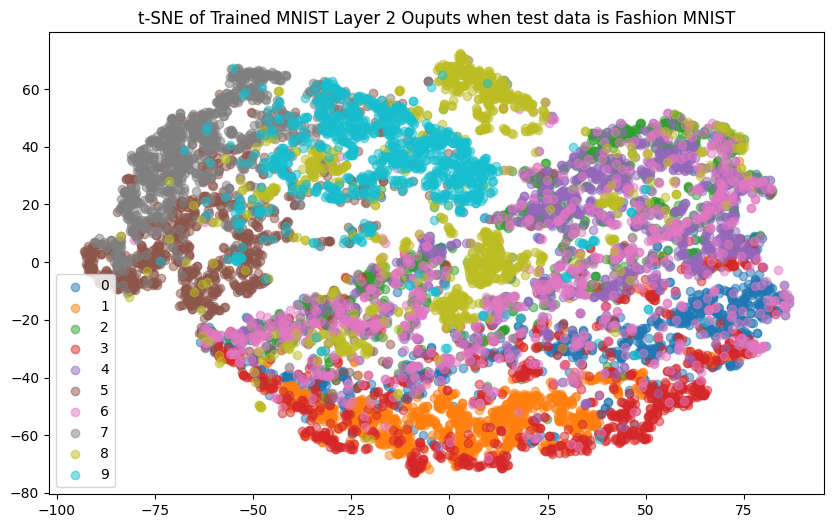

In [36]:
#using trained MLP to predict fashion mnist

predicted_fmnist = predict(net, f_test_data.to(device))
print("Accuracy is : ", calculate_accuracy(torch.argmax(predicted_fmnist, dim=1).cpu().numpy(), f_test_labels.numpy()))

f_trained_outputs = get_outputs(net, f_test_data, net.layer_2)
f_trained_outputs_tsne = tsne.fit_transform(f_trained_outputs)

plot_tsne(f_trained_outputs_tsne, f_test_labels.numpy(), "t-SNE of Trained MNIST Layer 2 Ouputs when test data is Fashion MNIST")

The accuracy is worse than randomnly guessing any of the ten classes. Also it is not very meaningful to predict in this way since the model doesnt exactly know the label mapping for the fashion dataset.

From the t-SNE plot we can see that :

There is an attempt at seperating the different classes, but it is not very useful per se when we pass the fashion MNIST data into the MLP trained on the MNIST dataset. The model being a Vanilla MLP has not learnt any low level features like edges etc which could help in a downstream task, which could be learnt by CNNs, and it is only suitable for testing on the MNIST dataset and hence we do not get any good result here. Another thing to note is the inability of the model to know the label mapping, one thing that could be done is to remove the output layer and retrain the MLP only for this level using the fashion MNIST dataset. This would yield somewhat better results.